In [1]:
#Import everything
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

#Functions defined here

#Extract indexed data

def get_inx(meta : dict):
    i = 1
    key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
    while key in meta:
        sort_locs.append(meta[key])
        i += 1
        key = f'INDEX SORTING LOCATIONS_{i}'
    sort_locs = ''.join(sort_locs).split(';')
    return sort_locs

#Plate QC - check that cells are in the expected locations
#Inputs are directory containing files and name to apply to the output file and figure legend


def plate_qc(directory, data_name):
    #Count the number of plates
    count = 0
    for filename in os.listdir(directory):
        count += 1

    plotlen = int(math.ceil(count/2))  

    #Set up the plots
    fig, ax = plt.subplots(plotlen, 2, figsize = (16,(plotlen*5)))
    ax = ax.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    count = -1

    xwell = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    ywell = [0,1,2,3,4,5,6,7,8,9,0,11,12,13,14,15]
    allwells = []

    for a in ywell: #this creates a list of all possible locations
        for b in xwell:
            allwells.append(str(a) + ','+ str(b))

    #Read in files and plot the data for each

    for filename in os.listdir(directory):
        fn = os.path.join(directory, filename)
        plateid = (fn.split('/'))[4]

        count += 1

        meta, data = fcsparser.parse(fn, reformat_meta=True)

        i = 1
        key = f'INDEX SORTING LOCATIONS_{i}'
        sort_locs = [] #Sort locations from the metadata, numerical row then column starting at 0
        while key in meta:
            sort_locs.append(meta[key])
            i += 1
            key = f'INDEX SORTING LOCATIONS_{i}'
        sort_locs = ''.join(sort_locs).split(';')

        for well in allwells:
            if well in sort_locs:  #if the well is in the list of wells with a sorted cell the colour will be darker
                alpha = 0.8
            else:
                alpha = 0.1        #plot empty wells in a lighter shade

            y, x = well.split(',')
            ax[count].scatter(x, y, alpha=alpha, color='gray')      
        ax[count].set_title(plateid)
        ax[count].invert_yaxis()  #flip the axis so the plate order looks natural
        ax[count].set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24'])
        ax[count].set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'])

    fig.suptitle(f'{data_name}', fontsize=14)    
    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_plate.png',dpi=300)     
    
    return

#Plot data per plate - works before assigning cell type

def CD34_data_input_comp(directory, plot = False):

    data_dict = {}
    data_dict_comp = {}

    plate_key = {'Sample_INX_AS0055-CD34_001_012.fcs': 'not_seq',
     'Sample_INX_AS0055-CD34_002_013.fcs': 'AS-197',
     'Sample_INX_AS0055-CD34_003_014.fcs': 'AS-198',
     'Sample_INX_AS0055-CD34_004_015.fcs': 'AS-201'}

    #Set up comp plots
    fig, ax = plt.subplots(2,2, figsize = (8,6))
    ax = ax.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    count = -1

    #Read in files and metadata

    for filename in os.listdir(directory):
        fn = os.path.join(directory, filename)
        plateid = (fn.split('/'))[4]
        count += 1

        meta, data = fcsparser.parse(fn, reformat_meta=True)

        sort_locs = get_inx(meta)

        wells = []
        for loc in sort_locs:
            if loc == '':
                continue
            row_index, col = loc.split(',')
            col = str(int(col)+1)
            row = chr(65 + int(row_index)) 
            well = row+col
            wells.append(well)   #Wells is a list of well locations with data derived from the index file

        # Get antibodies and rename with well names
        channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
        channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

        data.index = pd.Index(wells, name='Sorted well') #Renames index with well name

        # Load compensation
        comp_fields = meta['SPILL'].split(',')
        n = int(comp_fields[0])
        channels = comp_fields[1: n+1]
        matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 

        matrix = numpy.linalg.inv(matrix)

        spill_matrix = pd.DataFrame(
            matrix,
            index=channels,
            columns=channels,
        )  #spill_matrix is the comp matrix

        #Plots compensation matrix
        # Reorder the dyes by wavelength
        wls = [int(x.split('/')[0][-3:]) for x in channels]
        idx = np.argsort(wls)
        spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

        ax[count] = sns.heatmap(spill_by_wls, ax=ax[count])
        ax[count].set_title(plateid)


        #Apply comp and replace column names with antibodies
        data_comp = data.copy()
        compensation = spill_matrix

        for channel in channels:
            data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication

        #Store df and compdf for this iteration as a unique variable
        data_comp.rename(columns = channeld, inplace = True)
        data.rename(columns = channeld, inplace = True)

        plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
        data['Well'] = data.index.get_level_values(0)
        data_comp['Well'] = data_comp.index.get_level_values(0)
        data['Plate'] = plate #add new column with plate name
        data_comp['Plate'] = plate  #add new column with plate name
        data_dict_comp[plate] = data_comp #output df into a dictionary
        data_dict[plate] = data  #output df into a dictionary      

    fig.tight_layout()  
    
    if plot == False:
        plt.close() #comment out to view comp plots

    #Combine all data or data_comp df into a single large df for gating
    #CD34_alldata = data_dict['not_seq'].append(data_dict['AS-197'], ignore_index=True).append(data_dict['AS-198'], ignore_index=True).append(data_dict['AS-201'], ignore_index=True)
    #CD34_alldata_comp = data_dict_comp['not_seq'].append(data_dict_comp['AS-197'], ignore_index=True).append(data_dict_comp['AS-198'], ignore_index=True).append(data_dict_comp['AS-201'], ignore_index=True)

    #Will just return comp data unless raw data unhashed

    #Annatina's better solution
    #CD34_alldata = pd.concat(data_dict.values(), axis = 0)
    CD34_alldata_comp = pd.concat(data_dict_comp.values(), axis = 0)


    #Add column to combine plate and well
    #CD34_alldata['Plate_Well'] = CD34_alldata['Plate'].astype(str) + '_' + CD34_alldata['Well'].astype(str)
    CD34_alldata_comp['Plate_Well'] = CD34_alldata_comp['Plate'].astype(str) + '_' + CD34_alldata_comp['Well'].astype(str)
    
    return CD34_alldata_comp

def CD34flowplot_byplate(source, gates, data_name, plot = False):
#Function for plotting processed flow data by sourceplate (4 plates designated here)
#Currently set to colour 4th plate red (sorted for CD38 negative), can change # in col variable to swap to random colours
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files
    
    sourcedata = source.copy()
    
    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'Lin-PE-Cy5'], 
        ['CD34-PE', 'CD38-APC-cy7'],
        ['IL1RAP-APC', 'CD38-APC-cy7'],
        ['CD45RA-FITC', 'CD123-PE-Cy7'],
        ['CD45RA-FITC', 'CD90-BV421']
    ]


    #Define colour palette here, and make a new column for it 
    plates = sourcedata['Plate'].drop_duplicates().to_list()
    cols = ['gray', 'green', 'green', 'red'] #can replace the colours used here
    #cols = sns.color_palette('husl', n_colors = len(plates))
    palette = dict(zip(plates, cols))

    sourcedata['Colour'] = sourcedata['Plate'].map(palette)

    #Which fluorophores are on a log scale
    logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16) 

    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_plate.png',dpi=300) 
    
    if plot == False:
        plt.close()
    
#Assign cell type using defined gates

def CD34_celltype_assign(data, gates_in, data_name, save = False):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    data_in = data.copy()

    #Create boolean matrix based on gates in new columns

    data_in['CD34_pos'] = data_in['CD34-PE'] >= gates_in['CD34-PE']
    data_in['CD38_pos'] = data_in['CD38-APC-cy7'] >= gates_in['CD38-APC-cy7']
    data_in['CD38_neg'] = data_in['CD38-APC-cy7'] < gates_in['CD38-APC-cy7']
    data_in['IL1RAP_pos'] = data_in['IL1RAP-APC'] >= gates_in['IL1RAP-APC']
    data_in['IL1RAP_neg'] = data_in['IL1RAP-APC'] < gates_in['IL1RAP-APC']
    data_in['CD45RA_pos'] = data_in['CD45RA-FITC'] >= gates_in['CD45RA-FITC']
    data_in['CD45RA_neg'] = data_in['CD45RA-FITC'] < gates_in['CD45RA-FITC']
    data_in['CD123_pos'] = data_in['CD123-PE-Cy7'] >= gates_in['CD123-PE-Cy7']
    data_in['CD123_neg'] = data_in['CD123-PE-Cy7'] < gates_in['CD123-PE-Cy7']
    data_in['CD90_pos'] = data_in['CD90-BV421'] >= gates_in['CD90-BV421']
    data_in['CD90_neg'] = data_in['CD90-BV421'] < gates_in['CD90-BV421']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    mds_sc1 = ['CD34_pos','CD38_neg','IL1RAP_pos']
    mds_sc2 = ['CD34_pos','CD38_neg','CD45RA_pos']
    mds_sc3 = ['CD34_pos','CD38_neg','CD123_pos']
    hsc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_pos']
    mpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_neg']
    cmp = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_pos']
    gmp = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_pos']
    gmp2 = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_neg'] 
    mep = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_neg']


    markers = [
        'CD34_pos' ,
        'CD38_pos' ,
        'CD38_neg' ,
        'IL1RAP_pos' ,
        'CD45RA_pos' ,
        'CD45RA_neg' ,
        'CD123_pos' ,
        'CD123_neg' ,
        'CD90_pos' ,
        'CD90_neg'
    ]

    col_names = ['mds_sc1', 'mds_sc2','mds_sc2','hsc', 'mpp', 'cmp', 'gmp', 'gmp2','mep']
    celltypes = ['MDS_SC', 'MDS_SC','MDS_SC','HSC', 'MPP',  'CMP', 'GMP', 'GMP2', 'MEP']
    alltypes = [mds_sc1, mds_sc2, mds_sc3, hsc, mpp, cmp, gmp, gmp2, mep]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well
    if save == True:
        data_in.to_csv(f'../Data/{data_name}_index.tsv', sep = '\t')    #Save the big df to a file
        #wellID = data_in[['Plate_Well', 'celltype']] #don't need this and it make sthe fucntion fail for bulk cell

    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_celltype_dist.png',dpi=300) 
    
    return data_in

def CD34_celltype_assign_refine(data, gates_in, data_name, save = False):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    data_in = data.copy()

    #Create boolean matrix based on gates in new columns

    data_in['CD34_pos'] = data_in['CD34-PE'] >= gates_in['CD34-PE']
    data_in['CD38_pos'] = data_in['CD38-APC-cy7'] >= gates_in['CD38-APC-cy7']
    data_in['CD38_neg'] = data_in['CD38-APC-cy7'] < gates_in['CD38-APC-cy7']
    data_in['IL1RAP_pos'] = data_in['IL1RAP-APC'] >= gates_in['IL1RAP-APC']
    data_in['IL1RAP_neg'] = data_in['IL1RAP-APC'] < gates_in['IL1RAP-APC']
    data_in['CD45RA_pos'] = data_in['CD45RA-FITC'] >= gates_in['CD45RA-FITC']
    data_in['CD45RA_neg'] = data_in['CD45RA-FITC'] < gates_in['CD45RA-FITC']
    data_in['CD123_pos'] = data_in['CD123-PE-Cy7'] >= gates_in['CD123-PE-Cy7']
    data_in['CD123_neg'] = data_in['CD123-PE-Cy7'] < gates_in['CD123-PE-Cy7']
    data_in['CD90_pos'] = data_in['CD90-BV421'] >= gates_in['CD90-BV421']
    data_in['CD90_neg'] = data_in['CD90-BV421'] < gates_in['CD90-BV421']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    mds_sc1 = ['CD34_pos','CD38_neg','IL1RAP_pos']
    mds_sc2 = ['CD34_pos','CD38_neg','CD45RA_pos']
    mds_sc3 = ['CD34_pos','CD38_neg','CD123_pos']
    #hsc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_pos']
    #mpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_neg']
    healthy_sc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg']
    cmp = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_pos']
    gmp = ['CD34_pos','CD38_pos','CD45RA_pos']
    #gmp = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_pos']
    #gmp2 = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_neg'] 
    mep = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_neg']


    markers = [
        'CD34_pos' ,
        'CD38_pos' ,
        'CD38_neg' ,
        'IL1RAP_pos' ,
        'CD45RA_pos' ,
        'CD45RA_neg' ,
        'CD123_pos' ,
        'CD123_neg' ,
        'CD90_pos' ,
        'CD90_neg'
    ]

    col_names = ['mds_sc1', 'mds_sc2','mds_sc2','healthy_sc', 'cmp', 'gmp','mep']
    celltypes = ['MDS_SC', 'MDS_SC','MDS_SC','HEALTHY_SC',  'CMP', 'GMP', 'MEP']
    alltypes = [mds_sc1, mds_sc2, mds_sc3, healthy_sc, cmp, gmp, mep]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well
    if save == True:
        data_in.to_csv(f'../Data/{data_name}_index_refined.tsv', sep = '\t')    #Save the big df to a file
        #wellID = data_in[['Plate_Well', 'celltype']] #don't need this and it make sthe fucntion fail for bulk cell

    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_celltype_dist_refined.png',dpi=300) 
    
    return data_in

def CD34_celltype_assign_oldschema(data, gates_in, data_name, save = True):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    data_in = data.copy()

    #Create boolean matrix based on gates in new columns

    data_in['CD34_pos'] = data_in['CD34-PE'] >= gates_in['CD34-PE']
    data_in['CD38_pos'] = data_in['CD38-APC-cy7'] >= gates_in['CD38-APC-cy7']
    data_in['CD38_neg'] = data_in['CD38-APC-cy7'] < gates_in['CD38-APC-cy7']
    data_in['IL1RAP_pos'] = data_in['IL1RAP-APC'] >= gates_in['IL1RAP-APC']
    data_in['IL1RAP_neg'] = data_in['IL1RAP-APC'] < gates_in['IL1RAP-APC']
    data_in['CD45RA_pos'] = data_in['CD45RA-FITC'] >= gates_in['CD45RA-FITC']
    data_in['CD45RA_neg'] = data_in['CD45RA-FITC'] < gates_in['CD45RA-FITC']
    data_in['CD123_pos'] = data_in['CD123-PE-Cy7'] >= gates_in['CD123-PE-Cy7']
    data_in['CD123_neg'] = data_in['CD123-PE-Cy7'] < gates_in['CD123-PE-Cy7']
    data_in['CD90_pos'] = data_in['CD90-BV421'] >= gates_in['CD90-BV421']
    data_in['CD90_neg'] = data_in['CD90-BV421'] < gates_in['CD90-BV421']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    lsc = ['CD34_pos','CD38_neg','IL1RAP_pos']
    hsc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD90_pos']
    mpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD90_neg']
    lmpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_pos']
    cmp = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_pos']
    gmp = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_pos']
    gmp2 = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_neg'] 
    mep = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_neg']


    markers = [
        'CD34_pos' ,
        'CD38_pos' ,
        'CD38_neg' ,
        'IL1RAP_pos' ,
        'CD45RA_pos' ,
        'CD45RA_neg' ,
        'CD123_pos' ,
        'CD123_neg' ,
        'CD90_pos' ,
        'CD90_neg'
    ]

    col_names = ['lsc', 'hsc', 'mpp', 'lmpp', 'cmp', 'gmp', 'gmp2','mep']
    celltypes = ['LSC', 'HSC', 'MPP', 'LMPP', 'CMP', 'GMP', 'GMP2', 'MEP']
    alltypes = [lsc, hsc, mpp, lmpp, cmp, gmp, gmp2, mep]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well
    if save == True:
        data_in.to_csv(f'../Data/{data_name}_index_old_schema.tsv', sep = '\t')    #Save the big df to a file
        #wellID = data_in[['Plate_Well', 'celltype']]  #don't need this and it make sthe fucntion fail for bulk cells

    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_celltype_dist_old_schema.png',dpi=300) 
    
    return data_in
    

    
#Plot data coloured by cell type
#Needs processed data that has the assigned 'celltype' column. FAILS until fixing df return from above.

def CD34flowplot_bycelltype(source, gates, data_name, plot = False):
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files
    
    sourcedata = source.copy()
    
    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'Lin-PE-Cy5'], 
        ['CD34-PE', 'CD38-APC-cy7'],
        ['IL1RAP-APC', 'CD38-APC-cy7'],
        ['CD45RA-FITC', 'CD123-PE-Cy7'],
        ['CD45RA-FITC', 'CD90-BV421']
    ]


    #Define colour palette here, and make a new column for it 

    #ct = sourcedata['celltype'].drop_duplicates().to_list()
    #col = sns.color_palette('husl', n_colors = len(ct))
    #palette2 = dict(zip(ct, col))

    #sourcedata['Colour'] = sourcedata['celltype'].map(palette2)


    #Which fluorophores are on a log scale
    logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16)    
    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_celltype.png',dpi=300) 
    
    if plot == False:
        plt.close()
    
def PB_data_input_comp(directory, plot = False):
#Now read PB data into df and apply compensation, then output combined df with all rw or comp values

    #Create list of plate names for renaming and for iteration
    fileplates = []

    for filename in os.listdir(directory):
        fn = os.path.join(directory, filename)
        plateid = (fn.split('/'))[4]
        fileplates.append(plateid)


    #Note that one nBC plate has 2 index files associated - these are treated separately then the placeholder plate name replaced in the final df
    ampplates = ['not_seq_NE1','AS-189','not_seq_NE3','not_seq_NE4','AS-195','not_seq_Mono1','AS-187','AS-193','not_seq_Mono4','not_seq_Mono5','not_seq_nBC1','not_seq_nBC2','AS-194','not_seq_nBC4a','not_seq_nBC4','AS-196']
    #second list is missing the first plate name, use for iteration later
    ampplates2 = ['AS-189','not_seq_NE3','not_seq_NE4','AS-195','not_seq_Mono1','AS-187','AS-193','not_seq_Mono4','not_seq_Mono5','not_seq_nBC1','not_seq_nBC2','AS-194','not_seq_nBC4a','not_seq_nBC4','AS-196']

    #Now read data into df and apply compensation, then output combined df with all rw or comp values

    data_dict = {}
    data_dict_comp = {}

    plate_key = dict(zip(fileplates, ampplates))

    #Set up column rename dictionary - these were compiled by pulling a single index file df into excel to check column labels
    col_name = {
        'YG582/15-A':'CD16-PE',
        'YG670/30-A':'CD14-Pe-Cy5',
        'YG780/60-A':'CD56-PE-Cy7',
        'V450/50-A':'CD66b-BV421',
        'V610/20-A':'Zombie',
        'B530/30-A':'CD45-FITC',
        'R660/20-A':'Cd27-APC',
        'R780/60-A':'R780/60-A',
        'B695/40-A':'IgD-BB700'
    }

    #Count the number of plates
    count = 0
    for filename in os.listdir(directory):
        count += 1

    plotlen = int(math.ceil(count/2))

    #Set up comp plots
    fig, ax = plt.subplots(plotlen, 2, figsize = (8,(plotlen*3)))
    ax = ax.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    count = -1

    #Read in files and metadata

    for filename in os.listdir(directory):
        fn = os.path.join(directory, filename)
        plateid = (fn.split('/'))[4]
        count += 1

        meta, data = fcsparser.parse(fn, reformat_meta=True)

        sort_locs = get_inx(meta)

        wells = []
        for loc in sort_locs:
            if loc == '':
                continue
            row_index, col = loc.split(',')
            col = str(int(col)+1)
            row = chr(65 + int(row_index)) #JT changed this to 65 from 64 - 65 is unicode for A, locations start at 0 (was 1 in test plate)
            well = row+col
            wells.append(well)   #Wells is a list of well locations with data derived from the index file

        # Get antibodies and rename with well names
        channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
        channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

        data.index = pd.Index(wells, name='Sorted well') #Renames index with well name


        # Load compensation
        comp_fields = meta['SPILL'].split(',')
        n = int(comp_fields[0])
        channels = comp_fields[1: n+1]
        matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 

        matrix = numpy.linalg.inv(matrix)

        spill_matrix = pd.DataFrame(
            matrix,
            index=channels,
            columns=channels,
        )  #spill_matrix is the comp matrix

        #Plots compensation matrix
        # Reorder the dyes by wavelength
        wls = [int(x.split('/')[0][-3:]) for x in channels]
        idx = np.argsort(wls)
        spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

        ax[count] = sns.heatmap(spill_by_wls, ax=ax[count])
        ax[count].set_title(plateid)


        #Apply comp and replace column names with antibodies
        data_comp = data.copy()
        compensation = spill_matrix

        for channel in channels:
            data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication    

        #Store df and compdf for this iteration as a unique variable
        data_comp.rename(columns = channeld, inplace = True)
        data.rename(columns = channeld, inplace = True)

        plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
        data['Well'] = data.index.get_level_values(0)
        data_comp['Well'] = data_comp.index.get_level_values(0)
        data['Plate'] = plate #add new column with plate name
        data_comp['Plate'] = plate  #add new column with plate name
        data_dict_comp[plate] = data_comp #output df into a dictionary
        data_dict[plate] = data  #output df into a dictionary      

    fig.tight_layout() 
    
    if plot == False:
        plt.close()

    #Rename columns that have channel and not fluorophore for raw and comp data - realised that not all files had the channel correctly named
    for p in data_dict.keys():
        for c in col_name.keys():
            if c not in data_dict[p]:
                continue

            else:
                data_dict[p].rename(columns = {c:col_name[c]}, inplace = True)

    for p in data_dict_comp.keys():
        for c in col_name.keys():
            if c not in data_dict_comp[p]:
                continue

            else:
                data_dict_comp[p].rename(columns = {c:col_name[c]}, inplace = True)            

    #Combine all data or data_comp df into a single large df for gating
    #PB_alldata = data_dict['not_seq_NE1']
    #PB_alldata_comp = data_dict_comp['not_seq_NE1']

    #for p in ampplates2:
    #    PB_alldata = PB_alldata.append(data_dict[p], ignore_index=True)
    #    PB_alldata_comp = PB_alldata_comp.append(data_dict_comp[p], ignore_index=True)


    #Will just return comp data unless raw data unhashed

    #Annatina's better solution
    #PB_alldata = pd.concat(data_dict.values(), axis = 0)
    PB_alldata_comp = pd.concat(data_dict_comp.values(), axis = 0)


    #print((PB_alldata.shape[0])/15) #QC lines to check that there are 381 cells for each of 15 plates
    #print(PB_alldata.shape[0]) 

    #Need to rename ['Plate'] 'not_seq_nBC4a' to 'not_seq_nBC4' - this was the placeholder name given to the plate split over two inx files
    #PB_alldata['Plate'] = PB_alldata['Plate'].replace({'not_seq_nBC4a':'not_seq_nBC4'})
    PB_alldata_comp['Plate'] = PB_alldata_comp['Plate'].replace({'not_seq_nBC4a':'not_seq_nBC4'})


    #Add column to combine plate and well
    #PB_alldata['Plate_Well'] = PB_alldata['Plate'].astype(str) + '_' + PB_alldata['Well'].astype(str)
    PB_alldata_comp['Plate_Well'] = PB_alldata_comp['Plate'].astype(str) + '_' + PB_alldata_comp['Well'].astype(str)
    
    return PB_alldata_comp    
    
def PBflowplot_byplate(source, gates, data_name, plot = False):
#Function for plotting processed flow data by sourceplate (4 plates designated here)
#Currently set to colour 4th plate red (sorted for CD38 negative), can change # in col variable to swap to random colours
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files
    
    sourcedata = source.copy()
    
    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'CD56-PE-Cy7'], 
        ['CD45-FITC', 'IgD-BB700'],
        ['CD66b-BV421', 'CD16-PE'],
        ['CD14-Pe-Cy5', 'CD16-PE'],
        ['Cd27-APC', 'IgD-BB700']
    ]
    
    #Define colour palette here, and make a new column for it 
    
    plates = sourcedata['Plate'].drop_duplicates().to_list() #15 plates, 5 x NE, 5 x Mono, 5 x nBC
    col = sns.color_palette('husl', n_colors = 3)
    cols = [col[0], col[0],col[0],col[0],col[0], col[1], col[1],col[1],col[1],col[1], col[2], col[2],col[2],col[2],col[2]] #can replace the colours used here
    palette = dict(zip(plates, cols))

    sourcedata['Colour'] = sourcedata['Plate'].map(palette)

    #Which fluorophores are on a log scale
    logs = ['CD16-PE', 'CD14-Pe-Cy5', 'CD56-PE-Cy7', 'CD66b-BV421', 'Zombie', 'CD45-FITC', 'Cd27-APC', 'R780/60-A', 'IgD-BB700']

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16) 

    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_plate.png',dpi=300) 
    
        
    if plot == False:
        plt.close()
    
    #Assign cell type using defined gates

def PB_celltype_assign(data, gates_in, data_name, save = False):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    data_in = data.copy()
    
    #Create boolean matrix based on gates in new columns

    #logs = ['CD16-PE', 'CD14-Pe-Cy5', 'CD56-PE-Cy7', 'CD66b-BV421', 'Zombie', 'CD45-FITC', 'Cd27-APC', 'R780/60-A', 'IgD-BB700']
    
    data_in['CD45_pos'] = data_in['CD45-FITC'] >= gates_in['CD45-FITC']
    data_in['IgD_pos'] = data_in['IgD-BB700'] >= gates_in['IgD-BB700']
    data_in['IgD_neg'] = data_in['IgD-BB700'] < gates_in['IgD-BB700']
    data_in['CD27_pos'] = data_in['Cd27-APC'] >= gates_in['Cd27-APC']
    data_in['CD27_neg'] = data_in['Cd27-APC'] < gates_in['Cd27-APC']
    data_in['CD66b_pos'] = data_in['CD66b-BV421'] >= gates_in['CD66b-BV421']
    data_in['CD66b_neg'] = data_in['CD66b-BV421'] < gates_in['CD66b-BV421']
    data_in['CD16_pos'] = data_in['CD16-PE'] >= gates_in['CD16-PE']
    data_in['CD16_neg'] = data_in['CD16-PE'] < gates_in['CD16-PE']
    data_in['CD14_pos'] = data_in['CD14-Pe-Cy5'] >= gates_in['CD14-Pe-Cy5']
    data_in['CD14_neg'] = data_in['CD14-Pe-Cy5'] < gates_in['CD14-Pe-Cy5']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    nBC = ['CD45_pos','IgD_pos','CD27_neg']
    NE = ['CD45_pos','IgD_neg','CD66b_pos','CD16_pos']
    CD14pos_mono = ['CD45_pos','IgD_neg','CD66b_neg','CD16_pos','CD14_pos']
    CD14neg_mono = ['CD45_pos','IgD_neg','CD66b_neg','CD16_pos','CD14_neg']


    markers = [
        'CD45_pos' ,
        'IgD_pos' ,
        'IgD_neg' ,
        'CD27_pos' ,
        'CD66b_pos' ,
        'CD66b_neg' ,
        'CD16_pos' ,
        'CD14_pos' ,
        'CD14_neg' 
    ]

    col_names = ['nBC', 'NE', 'CD14pos_mono', 'CD14neg_mono']
    celltypes = ['nBC', 'NE', 'CD14pos_mono', 'CD14neg_mono']
    alltypes = [nBC, NE, CD14pos_mono, CD14neg_mono]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well
    if save == True:
        data_in.to_csv(f'../Data/{data_name}_index.tsv', sep = '\t')    #Save the big df to a file
        #wellID = data_in[['Plate_Well', 'celltype']]

    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_celltype_dist.png',dpi=300) 
    
    return data_in

def PBflowplot_bycelltype(source, gates, data_name, plot = False):
#3 inputs, sourcedata, gates, data_name
#sourcedata is the df containing the fcs data, possibly pre-compensated
#gates is the location of each gating line
#data_name is the name to be applied to legends and output files
    
    sourcedata = source.copy()
    
    #Here's what's being plotted

    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'CD56-PE-Cy7'], 
        ['CD45-FITC', 'IgD-BB700'],
        ['CD66b-BV421', 'CD16-PE'],
        ['CD14-Pe-Cy5', 'CD16-PE'],
        ['Cd27-APC', 'IgD-BB700']
    ]


    #Define colour palette here, and make a new column for it 

    ct = sourcedata['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette2 = dict(zip(ct, col))

    sourcedata['Colour'] = sourcedata['celltype'].map(palette2)


    #Which fluorophores are on a log scale
    logs = ['CD16-PE', 'CD14-Pe-Cy5', 'CD56-PE-Cy7', 'CD66b-BV421', 'Zombie', 'CD45-FITC', 'Cd27-APC', 'R780/60-A', 'IgD-BB700']


    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.3, c = sourcedata['Colour'], s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

    fig.suptitle(f'{data_name}', fontsize=16)    
    fig.savefig(f'../Results/Indexing/{data_name}_plot_by_celltype.png',dpi=300) 
    
    if plot == False:
        plt.close()
    
def CD34_plot_bulk(sample,backgrounddf, gates):
    #Annatina: modified your plotting function to plot a big background sample and a smaller foreground subset
    #Does not output a file
    
    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'Lin-PE-Cy5'], 
        ['CD34-PE', 'CD38-APC-cy7'],
        ['IL1RAP-APC', 'CD38-APC-cy7'],
        ['CD45RA-FITC', 'CD123-PE-Cy7'],
        ['CD45RA-FITC', 'CD90-BV421']
    ]
    
    #Which fluorophores are on a log scale
    logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(backgrounddf[x_label] + 11, backgrounddf[y_label] + 11, alpha = 0.005, c = 'silver', s = 5)
        ax.scatter(sample[x_label] + 11, sample[y_label] + 11, alpha = 0.2, c = sample['Colour'],  s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  
        
    fig.suptitle('CD34 bulk cells', fontsize=16)    
    fig.savefig(f'../Results/Indexing/RN_CD34_bulk_plot_by_celltype.png',dpi=300) 
    


In [2]:
#Set gates for each fluorophore. 
#Raw CD34 data
CD34_gate_loc = {
    'Lin-PE-Cy5': 2000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 3000 ,
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 400,
    'Zombie': 8000,
    'IL1RAP-APC': 800,
    'CD90-BV421': 500,
}

#Compensated data
CD34_gate_loc_comp = {
    'Lin-PE-Cy5': 1000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 1100 ,  #Originally 2500, have adjusted to 1100 as per AS calculation for lowest 10%. This is compatible with FlowJo analysis on total MNC
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 200,
    'Zombie': 8000,
    'IL1RAP-APC': 1400,  #set from FlowJo looking at FMOs
    'CD90-BV421': 500,
}

#Raw PB data
PB_gate_loc = {
    'CD16-PE': 500,
    'CD14-Pe-Cy5': 5000 ,
    'CD56-PE-Cy7': 1000 ,
    'CD66b-BV421': 2500 ,
    'Zombie': 2500,
    'CD45-FITC': 1000,
    'Cd27-APC': 3000,
    'IgD-BB700': 3500,
    'R780/60-A':1000
}

#Comp PB data
PB_gate_loc_comp = {
    'CD16-PE': 500,
    'CD14-Pe-Cy5': 1000 ,
    'CD56-PE-Cy7': 400 ,
    'CD66b-BV421': 2000 ,
    'Zombie': 1500,
    'CD45-FITC': 1000,
    'Cd27-APC': 1000,
    'IgD-BB700': 3500,
    'R780/60-A':1000
}

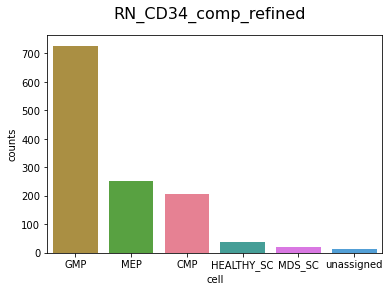

In [3]:
#CD34 analysis
CD34directory = '../Data/RN_BM/Indexed/'
CD34_alldata_comp = CD34_data_input_comp(CD34directory)
CD34flowplot_byplate(CD34_alldata_comp, CD34_gate_loc_comp, 'RN_CD34_comp', plot = False) #Plot with colour by origin plate; red cells were sorted CD38neg, green sorted CD34pos, grey cells are the bulk plate with no amplicon seq. 
#CD34_alldata_comp_ct = CD34_celltype_assign(CD34_alldata_comp, CD34_gate_loc_comp, 'RN_CD34_comp', save = True) #Assign cell types and plot the distribution
#CD34_alldata_comp_ct = CD34_celltype_assign_oldschema(CD34_alldata_comp, CD34_gate_loc_comp, 'RN_CD34_comp_old_schema', save = True)
CD34_alldata_comp_ct = CD34_celltype_assign_refine(CD34_alldata_comp, CD34_gate_loc_comp, 'RN_CD34_comp_refined', save = True)
CD34flowplot_bycelltype(CD34_alldata_comp_ct, CD34_gate_loc_comp, 'RN_CD34_comp_ct', plot = False) #plot by cell type

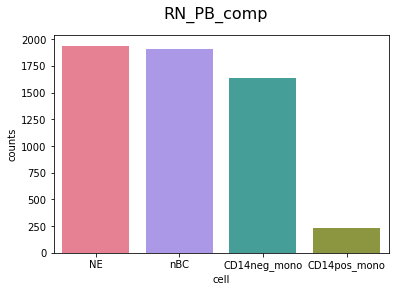

In [4]:
#PB analysis
PBdirectory = '../Data/RN_PB/Indexed/'
PB_alldata_comp = PB_data_input_comp(PBdirectory)
PBflowplot_byplate(PB_alldata_comp, PB_gate_loc_comp, 'RN_PB_comp', plot = False) #Plot with colour by origin plate.
PB_alldata_comp_ct = PB_celltype_assign(PB_alldata_comp, PB_gate_loc_comp, 'RN_PB_comp') #Assign cell types and plot the distribution
PBflowplot_bycelltype(PB_alldata_comp_ct, PB_gate_loc_comp, 'PB_comp_ct', plot = False) #Plot by cell type

In [5]:
#Now combine everything into a single df that contains the celltype and flow data for each well
#This is the key output for this notebook
print('Number of CD34 wells (expect 1259) = ', len(CD34_alldata_comp_ct))
print('Number of PB wells (expect 5715) = ',len(PB_alldata_comp_ct))
RN_alldata_comp_ct = CD34_alldata_comp_ct.append(PB_alldata_comp_ct, ignore_index=True)
print('Total number of wells = ', len(RN_alldata_comp_ct))
RN_alldata_comp_ct.to_csv(f'../Data/Amp_data/RN_comp_celltype_assignment.tsv', sep = '\t')    #Save the well assignment to a file

Number of CD34 wells (expect 1259) =  1259
Number of PB wells (expect 5715) =  5715
Total number of wells =  6974


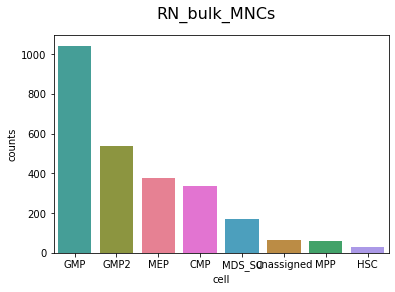

In [6]:
#Adding in some code to look at bulk cell data (currenlty only for CD34s)
# Get bulk-fcs files from AS

bulkdirectory = '../Data/RN_BM/Bulk/'

bulkdict = {}
bulkcompdict = {}
    
for filename in os.listdir(bulkdirectory):
    fn = os.path.join(bulkdirectory, filename)
    plateid = (fn.split('/'))[4]
    #count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)
    
    # Get antibodies and rename with well names: The fmo and single stains don't have the info in their metadata
    # therefore just pasting the correct dictionnary here
    
    channeld = {'YG582/15-A': 'CD34-PE',
     'YG670/30-A': 'Lin-PE-Cy5',
     'YG780/60-A': 'CD123-PE-Cy7',
     'V450/50-A': 'CD90-BV421',
     'V610/20-A': 'Zombie',
     'B530/30-A': 'CD45RA-FITC',
     'R660/20-A': 'IL1RAP-APC',
     'R780/60-A': 'CD38-APC-cy7'}
    
    # Load compensation
    comp_fields = meta['SPILL'].split(',')
    n = int(comp_fields[0])
    channels = comp_fields[1: n+1]
    matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
 
    matrix = numpy.linalg.inv(matrix)
    
    spill_matrix = pd.DataFrame(
        matrix,
        index=channels,
        columns=channels,
    )  #spill_matrix is the comp matrix
    
    #Plots compensation matrix
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    
    #Apply comp and replace column names with antibodies
    data_comp = data.copy()
    compensation = spill_matrix
    
    for channel in channels:
        data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication
    
    #Store df and compdf for this iteration as a unique variable
    data_comp.rename(columns = channeld, inplace = True)
    data.rename(columns = channeld, inplace = True)
    
    #plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
    plate = filename.strip(".fcs")
    data['Plate'] = plate #add new column with plate name
    data_comp['Plate'] = plate  #add new column with plate name
    bulkcompdict[plate] = data_comp #output df into a dictionary
    bulkdict[plate] = data  #output df into a dictionary
    
CD34_bulk = pd.concat(bulkdict.values(), axis = 0) #calculating uncomp, but don't use this again
CD34_bulkcomp = pd.concat(bulkcompdict.values(), axis = 0)

#Gate out a bunch of crap

sample = CD34_bulkcomp.copy()

bulkgate_loc_comp = {
    'FSC-A_lower' : 80000,
    'FSC-A_higher' : 225000,
    'SSC-A_lower' : 10000,
    'SSC-A_higher' : 130000,
    'Zombie' : 2500,
    'Lin-PE-Cy5' : 1000,
    'CD34-PE' : 280
}

sample = sample.loc[sample['SSC-A'] > bulkgate_loc_comp['SSC-A_lower']].copy()
sample = sample.loc[sample['SSC-A'] < bulkgate_loc_comp['SSC-A_higher']].copy()
sample = sample.loc[sample['FSC-A'] > bulkgate_loc_comp['FSC-A_lower']].copy()
sample = sample.loc[sample['FSC-A'] < bulkgate_loc_comp['FSC-A_higher']].copy()
sample = sample.loc[sample['Zombie'] < bulkgate_loc_comp['Zombie']].copy()
sample = sample.loc[sample['Lin-PE-Cy5'] < bulkgate_loc_comp['Lin-PE-Cy5']].copy()
sample = sample.loc[sample['CD34-PE'] > bulkgate_loc_comp['CD34-PE']].copy()

CD34_bulkcomp_pregate = sample.copy()

#Assign cell types to bulk data
CD34_bulkcomp_pregate_ct = CD34_celltype_assign(CD34_bulkcomp_pregate, CD34_gate_loc_comp, 'RN_bulk_MNCs', save = False)

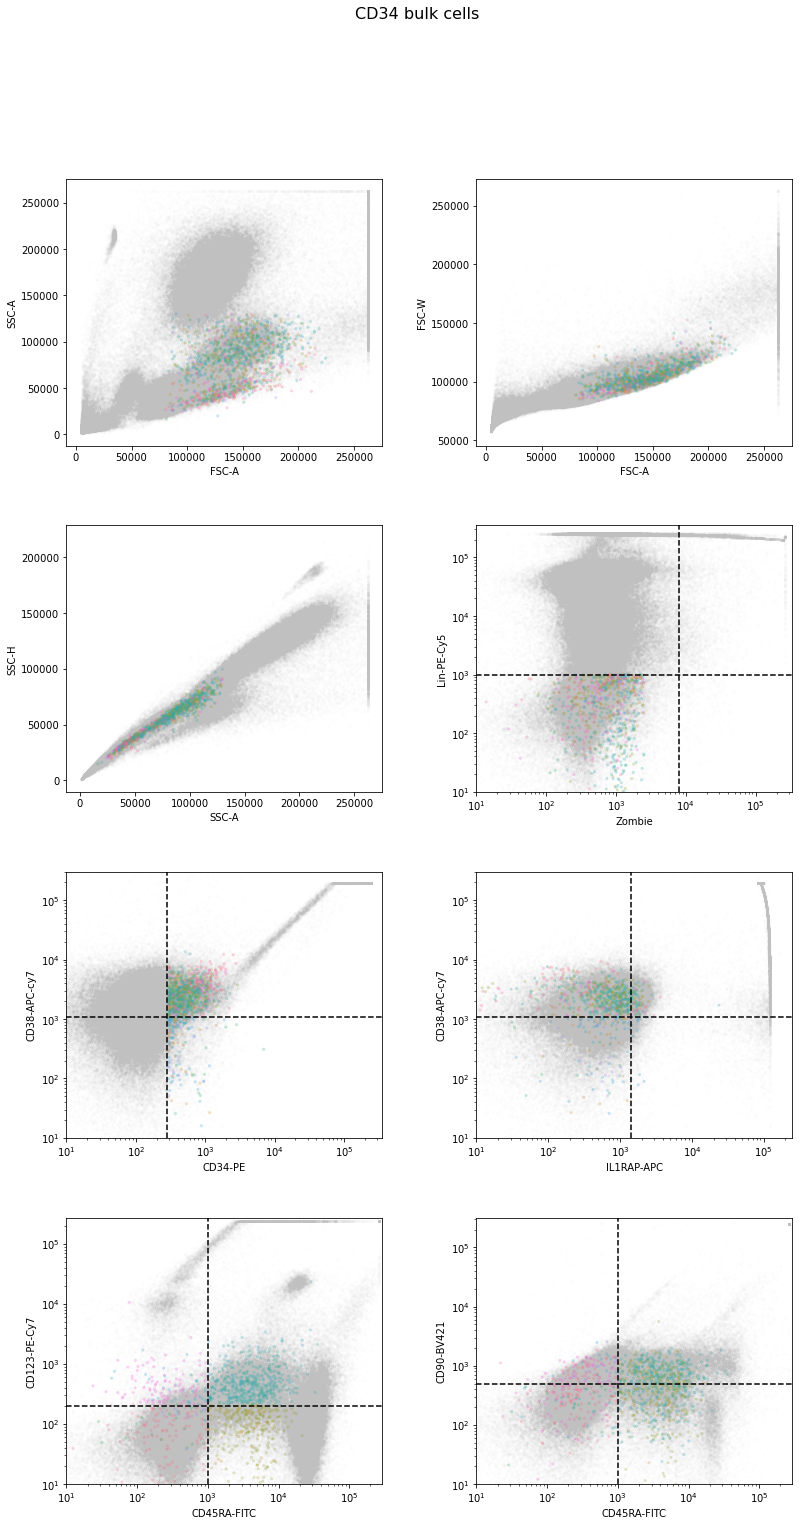

In [7]:
#Plot the data - background is stained MNCs
foreground = CD34_bulkcomp_pregate_ct.loc[CD34_bulkcomp_pregate['Plate'].isin(['FMO_123-PECY7_020', 'FMO_CD34-PE_016', 'FMO_CD38-APC-CY7_018', 'FMO_CD45RA-FITC_019', 'FMO_CD90-BV421_021', 'FMO_ILRAP-APC_022', 'FMO_LiPECy5_017','Sample_Unstained_010'])].copy()
background = CD34_bulkcomp.loc[CD34_bulkcomp['Plate'].isin(['Sample_MNC_011'])].copy()

CD34_plot_bulk(foreground,background, CD34_gate_loc_comp)